In [14]:
import os
import theano
from theano import *
import theano.tensor as tt
from theano.compile.ops import as_op
import matplotlib.pyplot as plt
from argparse import Namespace
import scipy.stats as stats 
import pandas as pd
import numpy as np
import pymc3 as pm
import argparse
import pickle
import json
import math
import sys  

sys.path.insert(0, '/Users/Yannis/code/fibe2-mini-project/models')
from LinearReservoirModel import LinearReservoirModel as LRM

In [15]:
colors = ['b','g','r','c','m','y']

# Import data

In [16]:
# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0])
if not rd.endswith('fibe2-mini-project'):
    rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0],'fibe2-mini-project')
    

In [17]:
with open(os.path.join(rd,'data','output','simulations/linear_reservoir_simulation_true_parameters.json'), 'r') as f:
    lrm_true_params = json.load(f)
lrm_true_args = Namespace(**lrm_true_params)

with open(os.path.join(rd,'data','output','simulations/nonlinear_reservoir_simulation_true_parameters.json'), 'r') as f:
    nlrm_true_params = json.load(f)
nlrm_true_args = Namespace(**nlrm_true_params)

with open(os.path.join(rd,'data','output','simulations/hymod_simulation_true_parameters.json'), 'r') as f:
    hymod_true_params = json.load(f)
hymod_true_args = Namespace(**hymod_true_params)

In [18]:
with open(os.path.join(rd,'data','output','posterior_samples/linear_reservoir_samples_priors.json'), 'r') as f:
    lrm_priors = json.load(f)
lrm_priors_args = Namespace(**lrm_priors)

with open(os.path.join(rd,'data','output','posterior_samples/nonlinear_reservoir_samples_priors.json'), 'r') as f:
    nlrm_priors = json.load(f)
nlrm_priors_args = Namespace(**nlrm_priors)

with open(os.path.join(rd,'data','output','posterior_samples/hymod_samples_priors.json'), 'r') as f:
    hymod_priors = json.load(f)
hymod_priors_args = Namespace(**hymod_priors)

## Sigma prior

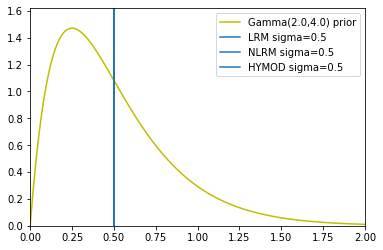

In [19]:
x = np.linspace(0, 2, 200)
y1 = stats.gamma.pdf(x, a=lrm_priors_args.alpha, scale=1/lrm_priors_args.beta)
y2 = stats.lognorm.pdf(x, s=0.5)
plt.plot(x, y1, "y-", label=(f'Gamma({lrm_priors_args.alpha},{lrm_priors_args.beta}) prior')) 
plt.axvline(x=lrm_true_args.sigma,label=f'LRM sigma={lrm_true_args.sigma}')
plt.axvline(x=nlrm_true_args.sigma,label=f'NLRM sigma={nlrm_true_args.sigma}')
plt.axvline(x=hymod_true_args.sigma,label=f'HYMOD sigma={hymod_true_args.sigma}')

plt.ylim([0,max(y1)*11/10])
plt.xlim([0,max(x)])
plt.legend()
plt.show()

## K priors

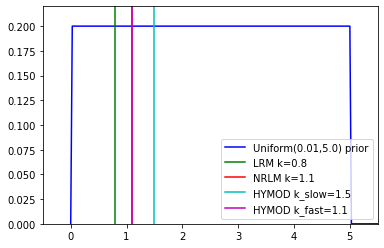

In [20]:
x = np.linspace(0, lrm_priors_args.kmax*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=lrm_priors_args.kmax)

plt.plot(x, y1, label=(f'Uniform(0.01,{lrm_priors_args.kmax}) prior'),color=colors[0]) 
plt.axvline(x=lrm_true_args.k,label=f'LRM k={lrm_true_args.k}',color=colors[1]) 
plt.axvline(x=nlrm_true_args.k,label=f'NRLM k={nlrm_true_args.k}',color=colors[2]) 
plt.axvline(x=hymod_true_args.kslow,label=f'HYMOD k_slow={hymod_true_args.kslow}',color=colors[3])
plt.axvline(x=hymod_true_args.kfast,label=f'HYMOD k_fast={hymod_true_args.kfast}',color=colors[4]) 

plt.ylim([0,max(y1)*11/10])
plt.xlim([-0.5,max(x)])
plt.legend()
plt.show()

# NLRM

## Prior over m

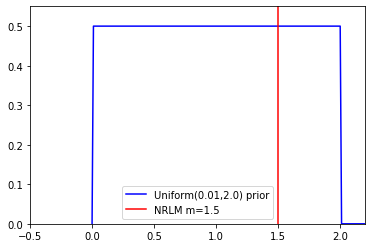

In [21]:
x = np.linspace(0, nlrm_priors_args.mmax*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=nlrm_priors_args.mmax)

plt.plot(x, y1, label=(f'Uniform(0.01,{nlrm_priors_args.mmax}) prior'),color=colors[0]) 
plt.axvline(x=nlrm_true_args.m,label=f'NRLM m={nlrm_true_args.m}',color=colors[2]) 

plt.ylim([0,max(y1)*11/10])
plt.xlim([-0.5,max(x)])
plt.legend()
plt.show()

# HYMOD

## C_max

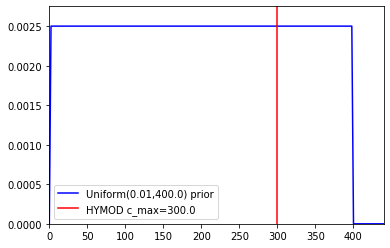

In [22]:
x = np.linspace(0, hymod_priors_args.c_max*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=hymod_priors_args.c_max)

plt.plot(x, y1, label=(f'Uniform(0.01,{hymod_priors_args.c_max}) prior'),color=colors[0]) 
plt.axvline(x=hymod_true_args.cmax,label=f'HYMOD c_max={hymod_true_args.cmax}',color=colors[2]) 

plt.ylim([0,max(y1)*11/10])
plt.xlim([-0.5,max(x)])
plt.legend()
plt.show()

## Beta_k prior

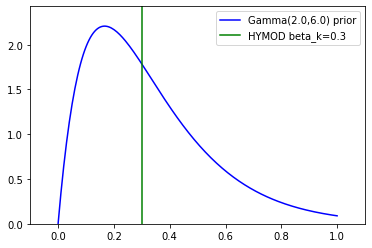

In [23]:
x = np.linspace(0, 1, 200) 
y1 = stats.gamma.pdf(x, a=hymod_priors_args.betak_alpha, scale=1/hymod_priors_args.betak_beta)

plt.plot(x, y1, label=(f'Gamma({hymod_priors_args.betak_alpha},{hymod_priors_args.betak_beta}) prior'),color=colors[0]) 
plt.axvline(x=hymod_true_args.betak,label=f'HYMOD beta_k={hymod_true_args.betak}',color=colors[1]) 

plt.ylim([0,max(y1)*11/10])
plt.xlim([-0.1,1.1])
plt.legend()
plt.show()

## Alfa prior

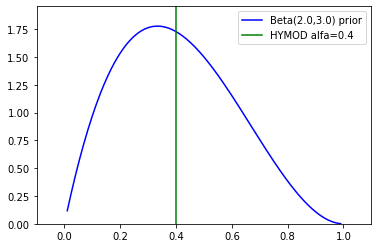

In [24]:
x = np.linspace(0.01, 0.99, 200) 
y1 = stats.beta.pdf(x, a=hymod_priors_args.alfa_alpha, b=hymod_priors_args.alfa_beta)

plt.plot(x, y1, label=(f'Beta({hymod_priors_args.alfa_alpha},{hymod_priors_args.alfa_beta}) prior'),color=colors[0])
plt.axvline(x=hymod_true_args.alfa,label=f'HYMOD alfa={hymod_true_args.alfa}',color=colors[1]) 

plt.ylim([0,max(y1)*11/10])
plt.xlim([-0.1,1.1])
plt.legend()
plt.show()